In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Importing all required libraries

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score, ConfusionMatrixDisplay
)
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import xgboost as xgb
import lightgbm as lgb
!pip install catboost
from catboost import CatBoostClassifier

# Install required libraries

In [11]:
!pip install catboost

# apply XGBoost, LightGBM and CatBoost models saperately

In [13]:
# Load dataset
df = pd.read_csv("/content/drive/MyDrive/final_cleaned_data.csv")

X = df.iloc[:, :-1]  # features
y = df.iloc[:, -1]   # target

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

def train_and_evaluate(model_name, model):
    print(f"\n===== {model_name} =====")
    model.fit(X_train, y_train)

    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_test_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues", values_format='d')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test, y_test_pred))

    # Evaluation Metrics
    metrics = {
        "Accuracy": accuracy_score(y_test, y_test_pred),
        "Precision": precision_score(y_test, y_test_pred, zero_division=0),
        "Recall": recall_score(y_test, y_test_pred, zero_division=0),
        "F1-score": f1_score(y_test, y_test_pred, zero_division=0),
        "ROC-AUC": roc_auc_score(y_test, y_test_proba) if y_test_proba is not None else None
    }
    print("\nEvaluation Metrics:")
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}" if v is not None else f"{k}: N/A")

    # Overfitting/Underfitting plot
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    plt.figure(figsize=(5, 4))
    plt.bar(["Train Accuracy", "Test Accuracy"], [train_acc, test_acc], color=['skyblue', 'orange'])
    plt.ylim(0, 1)
    plt.title(f"Overfitting/Underfitting Check - {model_name}")
    plt.show()

    return metrics



===== XGBoost =====


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [17:51:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


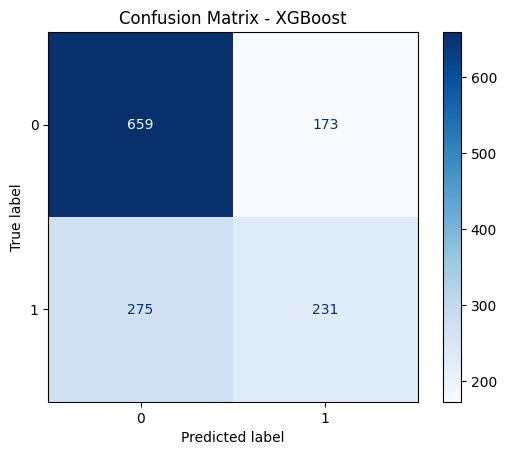


Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.79      0.75       832
           1       0.57      0.46      0.51       506

    accuracy                           0.67      1338
   macro avg       0.64      0.62      0.63      1338
weighted avg       0.65      0.67      0.66      1338


Evaluation Metrics:
Accuracy: 0.6652
Precision: 0.5718
Recall: 0.4565
F1-score: 0.5077
ROC-AUC: 0.6923


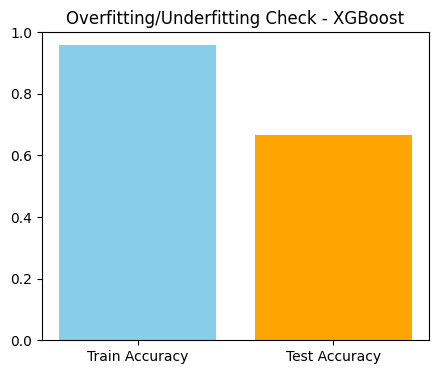

In [14]:
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_metrics = train_and_evaluate("XGBoost", xgb_model)



===== LightGBM =====
[LightGBM] [Info] Number of positive: 2023, number of negative: 3329
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000603 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 957
[LightGBM] [Info] Number of data points in the train set: 5352, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.377990 -> initscore=-0.498090
[LightGBM] [Info] Start training from score -0.498090


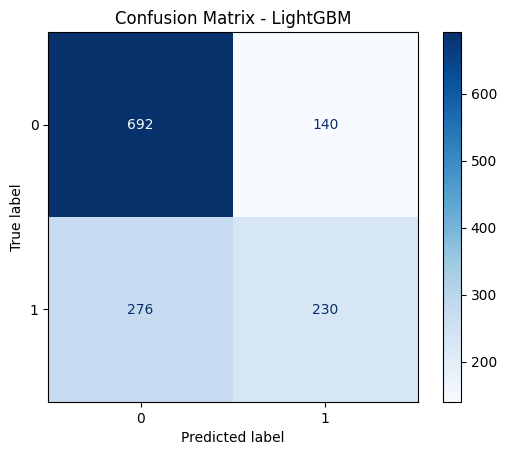


Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.83      0.77       832
           1       0.62      0.45      0.53       506

    accuracy                           0.69      1338
   macro avg       0.67      0.64      0.65      1338
weighted avg       0.68      0.69      0.68      1338


Evaluation Metrics:
Accuracy: 0.6891
Precision: 0.6216
Recall: 0.4545
F1-score: 0.5251
ROC-AUC: 0.7245


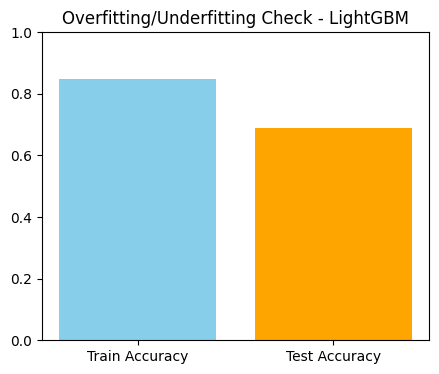

In [15]:
lgb_model = lgb.LGBMClassifier(random_state=42)
lgb_metrics = train_and_evaluate("LightGBM", lgb_model)



===== CatBoost =====


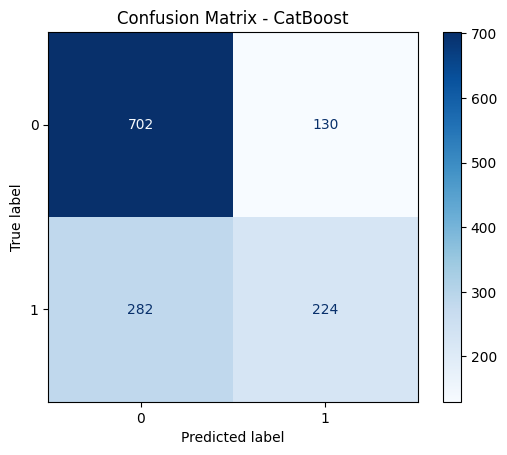


Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.84      0.77       832
           1       0.63      0.44      0.52       506

    accuracy                           0.69      1338
   macro avg       0.67      0.64      0.65      1338
weighted avg       0.68      0.69      0.68      1338


Evaluation Metrics:
Accuracy: 0.6921
Precision: 0.6328
Recall: 0.4427
F1-score: 0.5209
ROC-AUC: 0.7323


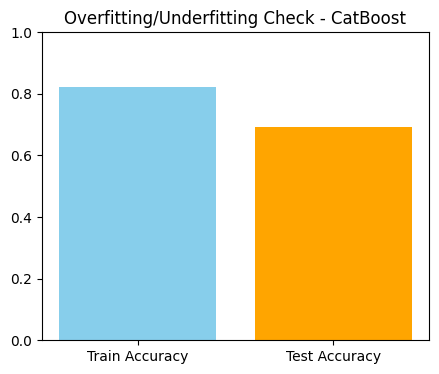

In [16]:
cat_model = CatBoostClassifier(verbose=0, random_state=42)
cat_metrics = train_and_evaluate("CatBoost", cat_model)


In [17]:
final_results = {
    "XGBoost": xgb_metrics,
    "LightGBM": lgb_metrics,
    "CatBoost": cat_metrics
}

summary_df = pd.DataFrame(final_results).T
print("\n===== Final Summary =====")
print(summary_df)



===== Final Summary =====
          Accuracy  Precision    Recall  F1-score   ROC-AUC
XGBoost   0.665172   0.571782  0.456522  0.507692  0.692308
LightGBM  0.689088   0.621622  0.454545  0.525114  0.724529
CatBoost  0.692078   0.632768  0.442688  0.520930  0.732256


# Apply Stack Ensemble model (Combination of XGBoost, LightGBM and CatBoost)

 Tuning XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [17:55:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best XGBoost params: {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 0.1, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 7, 'learning_rate': 0.01, 'colsample_bytree': 0.8}
 Training stacking model...

 Evaluation Metrics:
Accuracy: 0.6921
ROC-AUC: 0.7335
Precision: 0.6257
Recall: 0.4625
F1-score: 0.5318

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.83      0.77       832
           1       0.63      0.46      0.53       506

    accuracy                           0.69      1338
   macro avg       0.67      0.65      0.65      1338
weighted avg       0.68      0.69      0.68      1338


 Train vs Test Performance:
Accuracy: Train=0.8079 | Test=0.6921
ROC-AUC: Train=0.8931 | Test=0.7335
Precision: Train=0.7981 | Test=0.6257
Recall: Train=0.6584 | Test=0.4625
F1-score: Train=0.7216 | Test=0.5318


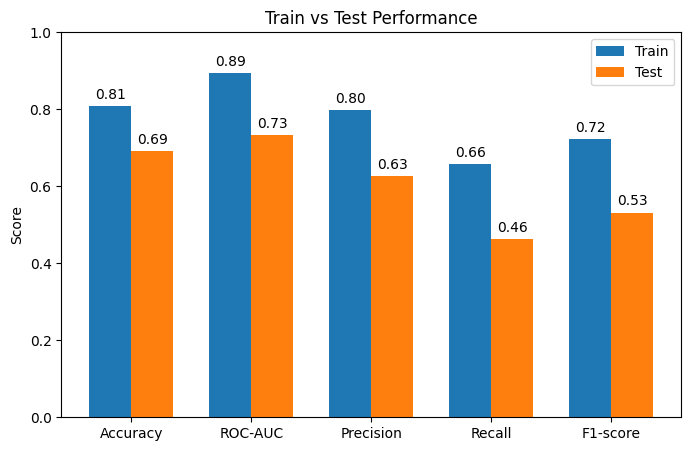

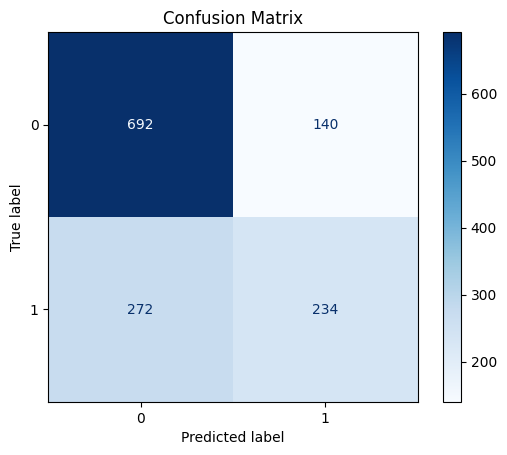

[LightGBM] [Info] Number of positive: 2023, number of negative: 3329
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000341 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 957
[LightGBM] [Info] Number of data points in the train set: 5352, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.377990 -> initscore=-0.498090
[LightGBM] [Info] Start training from score -0.498090

 Top 15 Features by Average Importance:


,XGBoost,LightGBM,CatBoost,Average_Importance
avg_TRAIL,0.093939,0.169000,0.135051,0.132663
Age,0.052995,0.200667,0.143900,0.132520
NACCMMSE,0.194385,0.069333,0.095082,0.119600
NACCBMI,0.054680,0.173333,0.125399,0.117804
ANIMALS,0.085725,0.097667,0.117194,0.100195
avg_craft,0.151738,0.064667,0.082477,0.099627
NACCNE4S,0.123910,0.037667,0.067431,0.076336
EDUC,0.052854,0.077333,0.086940,0.072376
avg_DIGI,0.054919,0.035333,0.040579,0.043610
DEP2YRS,0.051529,0.031000,0.041987,0.041505


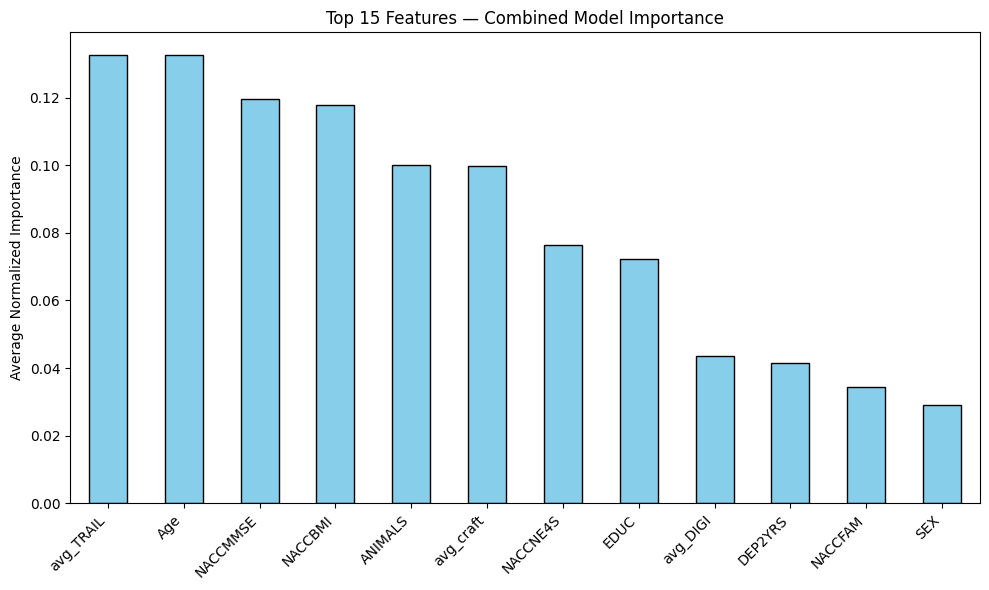

In [19]:
# ===========================
# Step 1 — Load dataset
# ===========================
file_path = "/content/drive/MyDrive/final_cleaned_data.csv"
df = pd.read_csv(file_path)


target_column = "event (1000 days)" # Replace with your target column name
X = df.drop(columns=[target_column])
y = df[target_column]

# ===========================
# Step 2 — Train/Test split
# ===========================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ===========================
# Step 3 — Define models
# ===========================
xgb_model = xgb.XGBClassifier(
    eval_metric="logloss",
    use_label_encoder=False,
    scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train)  # handle imbalance
)

lgb_model = lgb.LGBMClassifier()

cat_model = CatBoostClassifier(
    verbose=0,
    scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train)  # handle imbalance
)

# ===========================
# Step 4 — Hyperparameter tuning example (XGBoost)
# ===========================
param_grid_xgb = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1],
    'min_child_weight': [1, 3, 5],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 2, 5]
}

search_xgb = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_grid_xgb,
    n_iter=20,
    scoring='roc_auc',
    cv=3,
    random_state=42,
    n_jobs=-1
)

print(" Tuning XGBoost...")
search_xgb.fit(X_train, y_train)
xgb_best = search_xgb.best_estimator_
print("Best XGBoost params:", search_xgb.best_params_)

# ===========================
# Step 5 — Stacking Ensemble
# ===========================
stack_model = StackingClassifier(
    estimators=[
        ('xgb', xgb_best),
        ('lgb', lgb_model),
        ('cat', cat_model)
    ],
    final_estimator=LogisticRegression(max_iter=1000),
    n_jobs=-1
)

print(" Training stacking model...")
stack_model.fit(X_train, y_train)

# ===========================
# Step 6 — Evaluation
# ===========================
y_pred = stack_model.predict(X_test)
y_proba = stack_model.predict_proba(X_test)[:, 1]

print("\n Evaluation Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))



# ===== Overfitting/Underfitting Check =====
y_train_pred = stack_model.predict(X_train)
y_train_proba = stack_model.predict_proba(X_train)[:, 1]

metrics = {
    "Accuracy": (
        accuracy_score(y_train, y_train_pred),
        accuracy_score(y_test, y_pred)
    ),
    "ROC-AUC": (
        roc_auc_score(y_train, y_train_proba),
        roc_auc_score(y_test, y_proba)
    ),
    "Precision": (
        precision_score(y_train, y_train_pred),
        precision_score(y_test, y_pred)
    ),
    "Recall": (
        recall_score(y_train, y_train_pred),
        recall_score(y_test, y_pred)
    ),
    "F1-score": (
        f1_score(y_train, y_train_pred),
        f1_score(y_test, y_pred)
    )
}

# Print results
print("\n Train vs Test Performance:")
for m, (train_score, test_score) in metrics.items():
    print(f"{m}: Train={train_score:.4f} | Test={test_score:.4f}")

# ===== Plotting =====
labels = list(metrics.keys())
train_scores = [metrics[m][0] for m in labels]
test_scores = [metrics[m][1] for m in labels]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
rects1 = ax.bar(x - width/2, train_scores, width, label='Train')
rects2 = ax.bar(x + width/2, test_scores, width, label='Test')

ax.set_ylabel('Score')
ax.set_title('Train vs Test Performance')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.set_ylim(0, 1)

# Annotate bars
for rect in rects1 + rects2:
    height = rect.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

plt.show()


# ===== Confusion Matrix =====
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix")

plt.show()

# ===========================
# Step 7 — Combined Feature Importance
# ===========================
import matplotlib.pyplot as plt

def get_feature_importance(model, feature_names, model_name):
    """Get normalized feature importance as a Pandas Series."""
    if hasattr(model, "feature_importances_"):
        imp = np.array(model.feature_importances_, dtype=float)
    elif hasattr(model, "get_feature_importance"):  # for CatBoost
        imp = np.array(model.get_feature_importance(), dtype=float)
    else:
        raise AttributeError(f"{model_name} does not provide feature importance.")

    if imp.sum() > 0:
        imp /= imp.sum()  # normalize
    return pd.Series(imp, index=feature_names, name=model_name)

# Get feature importances from the tuned XGB model and the base LGB, CatBoost
xgb_imp = get_feature_importance(xgb_best, X.columns, "XGBoost")
lgb_imp = get_feature_importance(lgb_model.fit(X_train, y_train), X.columns, "LightGBM")
cat_imp = get_feature_importance(cat_model.fit(X_train, y_train), X.columns, "CatBoost")

# Combine and compute average
importance_df = pd.concat([xgb_imp, lgb_imp, cat_imp], axis=1)
importance_df["Average_Importance"] = importance_df.mean(axis=1)

# Sort by average
importance_df = importance_df.sort_values("Average_Importance", ascending=False)

# Show top 50
print("\n Top 15 Features by Average Importance:")
display(importance_df.head(15))

# Plot top 50
plt.figure(figsize=(10, 6))
importance_df["Average_Importance"].head(15).plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Top 15 Features — Combined Model Importance")
plt.ylabel("Average Normalized Importance")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()
